v1 + :
- self-attention
- positional encoding (check transformer paper)
    - https://youtu.be/kCc8FmEb1nY?t=3628

Source:
- https://youtu.be/kCc8FmEb1nY?t=2283
- https://github.com/karpathy/ng-video-lecture/blob/master/bigram.py

In [1]:
import os; os.chdir('..')
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch import nn
from torch.nn import functional as F
import math

from utils import *
from boring_utils.utils import init_graph, set_seed, get_device, cprint, tprint
from utils import add_to_class

In [3]:
init_graph()
set_seed(1337)
device = get_device()

# Hyperparameters

In [4]:
set_seed(1337)
batch_size = 32 # how many independent sequences to train on in parallel
block_size = 8  # what is the maximum concatenated length for predictions
max_len = 10  # let's keep the model small
max_iters = 3000
eval_interval = 300
learning_rate = 1e-3
device = get_device()
eval_iters = 200
n_embed = 32
dropout = 0.2

# Encode and Decode Function

In [5]:
input_file_path = './data/shakespeare_char/input.txt'

with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
print("stoi:", stoi)
print("itos:", itos)

def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers

def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
stoi: {'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}
itos: {0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q'

In [6]:
def test_decode(net, max_new_tokens=100):
    gen = net.generate(
            torch.zeros((1, 1), dtype=torch.long, device=device),
            max_new_tokens=max_new_tokens
        )
    print(gen)
    print(decode(gen[0].tolist()))

In [7]:
train_bin_path = './data/shakespeare_char/train.bin'
val_bin_path = './data/shakespeare_char/val.bin'

# train_tensor = torch.tensor(encode(data), dtype=torch.long) # convert to tensor

# torch.long is just an alias for torch.int64
# load the binary data
train_data = np.fromfile(train_bin_path, dtype=np.uint16)
val_data = np.fromfile(val_bin_path, dtype=np.uint16)

# convert to pytorch tensors
train_tensor = torch.from_numpy(train_data.astype(np.int64))
val_tensor = torch.from_numpy(val_data.astype(np.int64))

print(train_tensor.shape, train_tensor.dtype)
print(val_tensor.shape, val_tensor.dtype)


torch.Size([1003854]) torch.int64
torch.Size([111540]) torch.int64


# Attention

checkout `attention.ipynb`

In [8]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

# NN with Positional Encoding and Self-Attention
Another thing to notice is `nn.Embedding` behaves the same during training and inference mode

## `nn.Embedding` Positional Encoding

In [9]:
class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embed)
        self.position_embedding = nn.Embedding(block_size, n_embed)  # positional encoding
        self.sa_head = Head(n_embed)  # self-attention head
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape  # B: batch_size, T: block_size

        # idx - (batch_size, block_size)
        # tok_emb - B, T, C: (batch_size, block_size, embedding_dim)
        tok_emb = self.token_embedding(idx)  
        # pos_emb - T, C: (block_size, embedding_dim)
        pos_emb = self.position_embedding(torch.arange(T, device=device))  

        x = tok_emb + pos_emb  # B, T, C: (batch_size, block_size, embedding_dim)
        x = self.sa_head(x)  # B, T, C: (batch_size, block_size, embedding_dim)
        # logits = self.lm_head(tok_emb)  # B, T, V: (batch_size, block_size, vocab_size)
        logits = self.lm_head(x)  # B, T, V: (batch_size, block_size, vocab_size)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)  # (batch_size * block_size, embedding_dim)
            targets = targets.view(-1)  # (batch_size * block_size)
            loss = F.cross_entropy(logits, targets)

        return logits, loss


## sin / cos Positional Encoding

```python
# = 1/10000
torch.exp(
    torch.tensor([-(math.log(10000.0))])
)
```

- `math.exp(math.log(10000.0) / n_embed)` => `10000 ** 1/n_embed`
- `math.log(x/y) = math.log(x) - math.log(y)`

`torch.sin(pos * div_term)` -> pos from arange(max_len), div_term from arange(n_embed) + odd even

In [10]:
def create_positional_encoding(max_len, n_embed, device):
    """
    Create positional encoding with the specified maximum length `max_len` 
    and embedding size `n_embed`.
    """
    # Create positional encoding matrix with size max_len x n_embed
    pe = torch.zeros(max_len, n_embed, device=device)
    
    # Create a tensor that represents the positions
    pos = torch.arange(max_len, dtype=torch.float32, device=device).unsqueeze(1)
    
    # Compute the positional encodings once, using the formula provided
    # two implementations of the same formula
    # div_term = torch.exp(-math.log(10000.0) * torch.arange(0, n_embed, 2, dtype=torch.float32) / n_embed).to(device)
    div_term = 1 / torch.pow(10000, torch.arange(0, n_embed, 2, dtype=torch.float32) / n_embed).to(device)
    pe[:, 0::2] = torch.sin(pos * div_term)
    pe[:, 1::2] = torch.cos(pos * div_term)
    
    return pe, pos, div_term

### demo 1

In [ ]:
# don't use an easy n_embed like 8 or 16, it will be misleading
pe, pos, div_term = create_positional_encoding(max_len=6, n_embed=10, device=device)

In [11]:
# pos, max_len
cprint(pos)
cprint(pos.shape)

# div term, n_embed/2
cprint(div_term)
cprint(div_term.shape)

# before sin or cos
cprint(pos * div_term)

pos: 
tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.]], device='mps:0')

pos.shape: 
torch.Size([6, 1])

div_term: 
tensor([1.0000e+00, 1.5849e-01, 2.5119e-02, 3.9811e-03, 6.3096e-04],
       device='mps:0')

div_term.shape: 
torch.Size([5])

pos * div_term: 
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.5849e-01, 2.5119e-02, 3.9811e-03, 6.3096e-04],
        [2.0000e+00, 3.1698e-01, 5.0238e-02, 7.9621e-03, 1.2619e-03],
        [3.0000e+00, 4.7547e-01, 7.5357e-02, 1.1943e-02, 1.8929e-03],
        [4.0000e+00, 6.3396e-01, 1.0048e-01, 1.5924e-02, 2.5238e-03],
        [5.0000e+00, 7.9245e-01, 1.2559e-01, 1.9905e-02, 3.1548e-03]],
       device='mps:0')



In [12]:
# positional encoding
cprint(pe)
cprint(pe.shape)

# sin and cos
cprint(pe[:, 0::2])
cprint(pe[:, 1::2])

pe: 
tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  1.5783e-01,  9.8747e-01,  2.5116e-02,
          9.9968e-01,  3.9811e-03,  9.9999e-01,  6.3096e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  3.1170e-01,  9.5018e-01,  5.0217e-02,
          9.9874e-01,  7.9621e-03,  9.9997e-01,  1.2619e-03,  1.0000e+00],
        [ 1.4112e-01, -9.8999e-01,  4.5775e-01,  8.8908e-01,  7.5285e-02,
          9.9716e-01,  1.1943e-02,  9.9993e-01,  1.8929e-03,  1.0000e+00],
        [-7.5680e-01, -6.5364e-01,  5.9234e-01,  8.0569e-01,  1.0031e-01,
          9.9496e-01,  1.5924e-02,  9.9987e-01,  2.5238e-03,  1.0000e+00],
        [-9.5892e-01,  2.8366e-01,  7.1207e-01,  7.0211e-01,  1.2526e-01,
          9.9212e-01,  1.9904e-02,  9.9980e-01,  3.1548e-03,  1.0000e+00]],
       device='mps:0')

pe.shape: 
torch.Size([6, 10])

pe[:, 0::2]: 
tensor([[ 0.0000e+00,  0.0000e

### demo 2

In [22]:
# don't use an easy n_embed like 8 or 16, it will be misleading
pe, pos, div_term = create_positional_encoding(max_len=10000, n_embed=10000, device=device)

In [27]:
# div term, n_embed/2
cprint(div_term[:10])
cprint(div_term[-10:])
cprint(div_term.shape)

div_term[:10]: 
tensor([1.0000, 0.9982, 0.9963, 0.9945, 0.9927, 0.9908, 0.9890, 0.9872, 0.9854,
        0.9836], device='mps:0')

div_term[-10:]: 
tensor([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001], device='mps:0')

div_term.shape: 
torch.Size([5000])



In [26]:
# sin
cprint(pe[:10, 0:10:2])
cprint(pe[:10, -10::2])

# cos
cprint(pe[:10, 1:10:2])
cprint(pe[:10, -9::2])

pe[:10, 0:10:2]: 
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.8405,  0.8395,  0.8385,  0.8375],
        [ 0.9093,  0.9108,  0.9123,  0.9138,  0.9153],
        [ 0.1411,  0.1466,  0.1520,  0.1575,  0.1629],
        [-0.7568, -0.7520, -0.7471, -0.7422, -0.7373],
        [-0.9589, -0.9615, -0.9640, -0.9664, -0.9687],
        [-0.2794, -0.2900, -0.3005, -0.3110, -0.3214],
        [ 0.6570,  0.6472,  0.6374,  0.6274,  0.6174],
        [ 0.9894,  0.9914,  0.9932,  0.9948,  0.9962],
        [ 0.4121,  0.4272,  0.4420,  0.4568,  0.4714]], device='mps:0')

pe[:10, -10::2]: 
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
        [0.0002, 0.0002, 0.0002, 0.0002, 0.0002],
        [0.0003, 0.0003, 0.0003, 0.0003, 0.0003],
        [0.0004, 0.0004, 0.0004, 0.0004, 0.0004],
        [0.0005, 0.0005, 0.0005, 0.0005, 0.0005],
        [0.0006, 0.0006, 0.0006, 0.0006, 0.0006],
        [0.0007, 0.0007, 0.0007, 0.0007, 0.000

### Added to BigramLanguageModel

In [ ]:
class BigramLanguageModel_b(nn.Module):
    def __init__(self, vocab_size, n_embed, block_size, device):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_embed = n_embed
        self.block_size = block_size
        self.device = device
        
        self.token_embedding = nn.Embedding(vocab_size, n_embed)
        # Remove the position_embedding as nn.Embedding
        self.sa_head = Head(n_embed)  # Assuming Head is defined elsewhere as self-attention head
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def positional_encoding(self, seq_len, n_embed):
        """Generate sinusoidal positional encodings."""
        position = torch.arange(seq_len, dtype=torch.float, device=self.device).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, n_embed, 2).float() * -(math.log(10000.0) / n_embed)
        )
        
        pe = torch.zeros(seq_len, n_embed, device=self.device)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        return pe

    def forward(self, idx, targets=None):
        B, T = idx.shape  # B: batch_size, T: block_size
        
        tok_emb = self.token_embedding(idx)  # B, T, C: (batch_size, block_size, embedding_dim)
        pos_emb = self.positional_encoding(seq_len=T, n_embed=self.n_embed)  # ! position embedding with sinusoidal
        
        x = tok_emb + pos_emb.unsqueeze(0)  # Expand dims to add batch_size dim and then add to tok_emb
        x = self.sa_head(x)  # B, T, C: (batch_size, block_size, embedding_dim)
        logits = self.lm_head(x)  # B, T, V: (batch_size, block_size, vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)  # (batch_size * block_size, vocab_size)
            targets = targets.view(-1)  # (batch_size * block_size)
            loss = F.cross_entropy(logits, targets)

        return logits, loss


In [11]:
# in prepare.py, we have:
# chars = sorted(list(set(data)))
# vocab_size = len(chars)

# m = BigramLanguageModel()
m = BigramLanguageModel_b()
m.to(device)
# logits, loss = m(xb, yb)
# print(logits.shape, logits.dtype)
# print(loss)  # so currently this is worse than random guessing

BigramLanguageModel(
  (token_embedding): Embedding(65, 32)
  (position_embedding): Embedding(8, 32)
  (sa_head): Head(
    (key): Linear(in_features=32, out_features=32, bias=False)
    (query): Linear(in_features=32, out_features=32, bias=False)
    (value): Linear(in_features=32, out_features=32, bias=False)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (lm_head): Linear(in_features=32, out_features=65, bias=True)
)

In [12]:
@add_to_class(BigramLanguageModel)
def generate(self, idx, max_new_tokens):
    # idx is (batch_size, block_size)
    for _ in range(max_new_tokens):
        # new: crop idx to the last block_size tokens
        # mainly to avoid errors for self.position_embedding
        idx_cond = idx[:, -block_size:]  # (batch_size, block_size)

        # get the predictions
        # logits, _ = self.forward(idx, None)
        # logits, _ = self(idx)
        logits, _ = self(idx_cond)

        # focus only the last time stemp
        logits = logits[:, -1, :]  # (batch_size, embedding_dim)
        probs = F.softmax(logits, dim=-1)

        # sample from distrubution
        idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # append sampled idx to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, T + 1)

    return idx

In [13]:
test_decode(m)

tensor([[ 0, 55, 11, 40, 49, 38, 26, 41, 61,  6, 32, 27, 27,  6, 40, 23, 40,  2,
         48, 49, 14, 36,  3, 10, 39, 60, 27,  9, 31, 10, 12, 24, 39, 46, 10, 34,
         22, 46, 44, 59, 55, 28, 62,  8, 40, 56, 42, 50, 16, 39, 43, 18,  9, 20,
         54, 35,  6, 16, 38, 37, 62, 15, 51, 36, 37, 30,  3, 25, 53, 34, 17, 60,
          2,  4,  2, 35, 23,  2, 35,  6, 43,  1, 56, 43, 17, 52, 41, 11, 50, 35,
         20, 19, 42, 53,  1, 57, 36, 14, 55, 49, 22]], device='cuda:0')

q;bkZNcw,TOO,bKb!jkBX$:avO3S:?Lah:VJhfuqPx.brdlDaeF3HpW,DZYxCmXYR$MoVEv!&!WK!W,e reEnc;lWHGdo sXBqkJ


# Training the NN

[torch.optim.Optimizer.zero_grad — PyTorch 2.0 documentation](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html)

In [14]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [15]:
loss_list = []

for steps in range(max_iters):
    if steps % eval_interval == 0 or iter == max_iters - 1:
        # in fp16 mode, we use autocast to automatically cast the data to half precision
        # ctx = nullcontext() if device == 'cpu' else torch.amp.autocast(device_type=device, dtype=ptdtype)
        losses = estimate_loss_np(m, eval_iters, train_data, val_data, block_size=block_size, batch_size=batch_size, device=device)
        # losses = estimate_loss(m)
        print(f"step: {steps}, train loss: {losses['train']:.4f}, val loss: {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch_np(train_data, block_size=block_size, batch_size=batch_size, device=device)

    # evaluate the loss
    logits, loss = m(xb, yb)
    # interesting...
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if steps % 200 == 0:
        loss_list.append(loss.item())


step: 0, train loss: 4.2000, val loss: 4.2047
step: 300, train loss: 2.9114, val loss: 2.9268
step: 600, train loss: 2.6774, val loss: 2.6892
step: 900, train loss: 2.5907, val loss: 2.5921
step: 1200, train loss: 2.5505, val loss: 2.5445
step: 1500, train loss: 2.5154, val loss: 2.5198
step: 1800, train loss: 2.4948, val loss: 2.4965
step: 2100, train loss: 2.4784, val loss: 2.4760
step: 2400, train loss: 2.4628, val loss: 2.4762
step: 2700, train loss: 2.4544, val loss: 2.4687


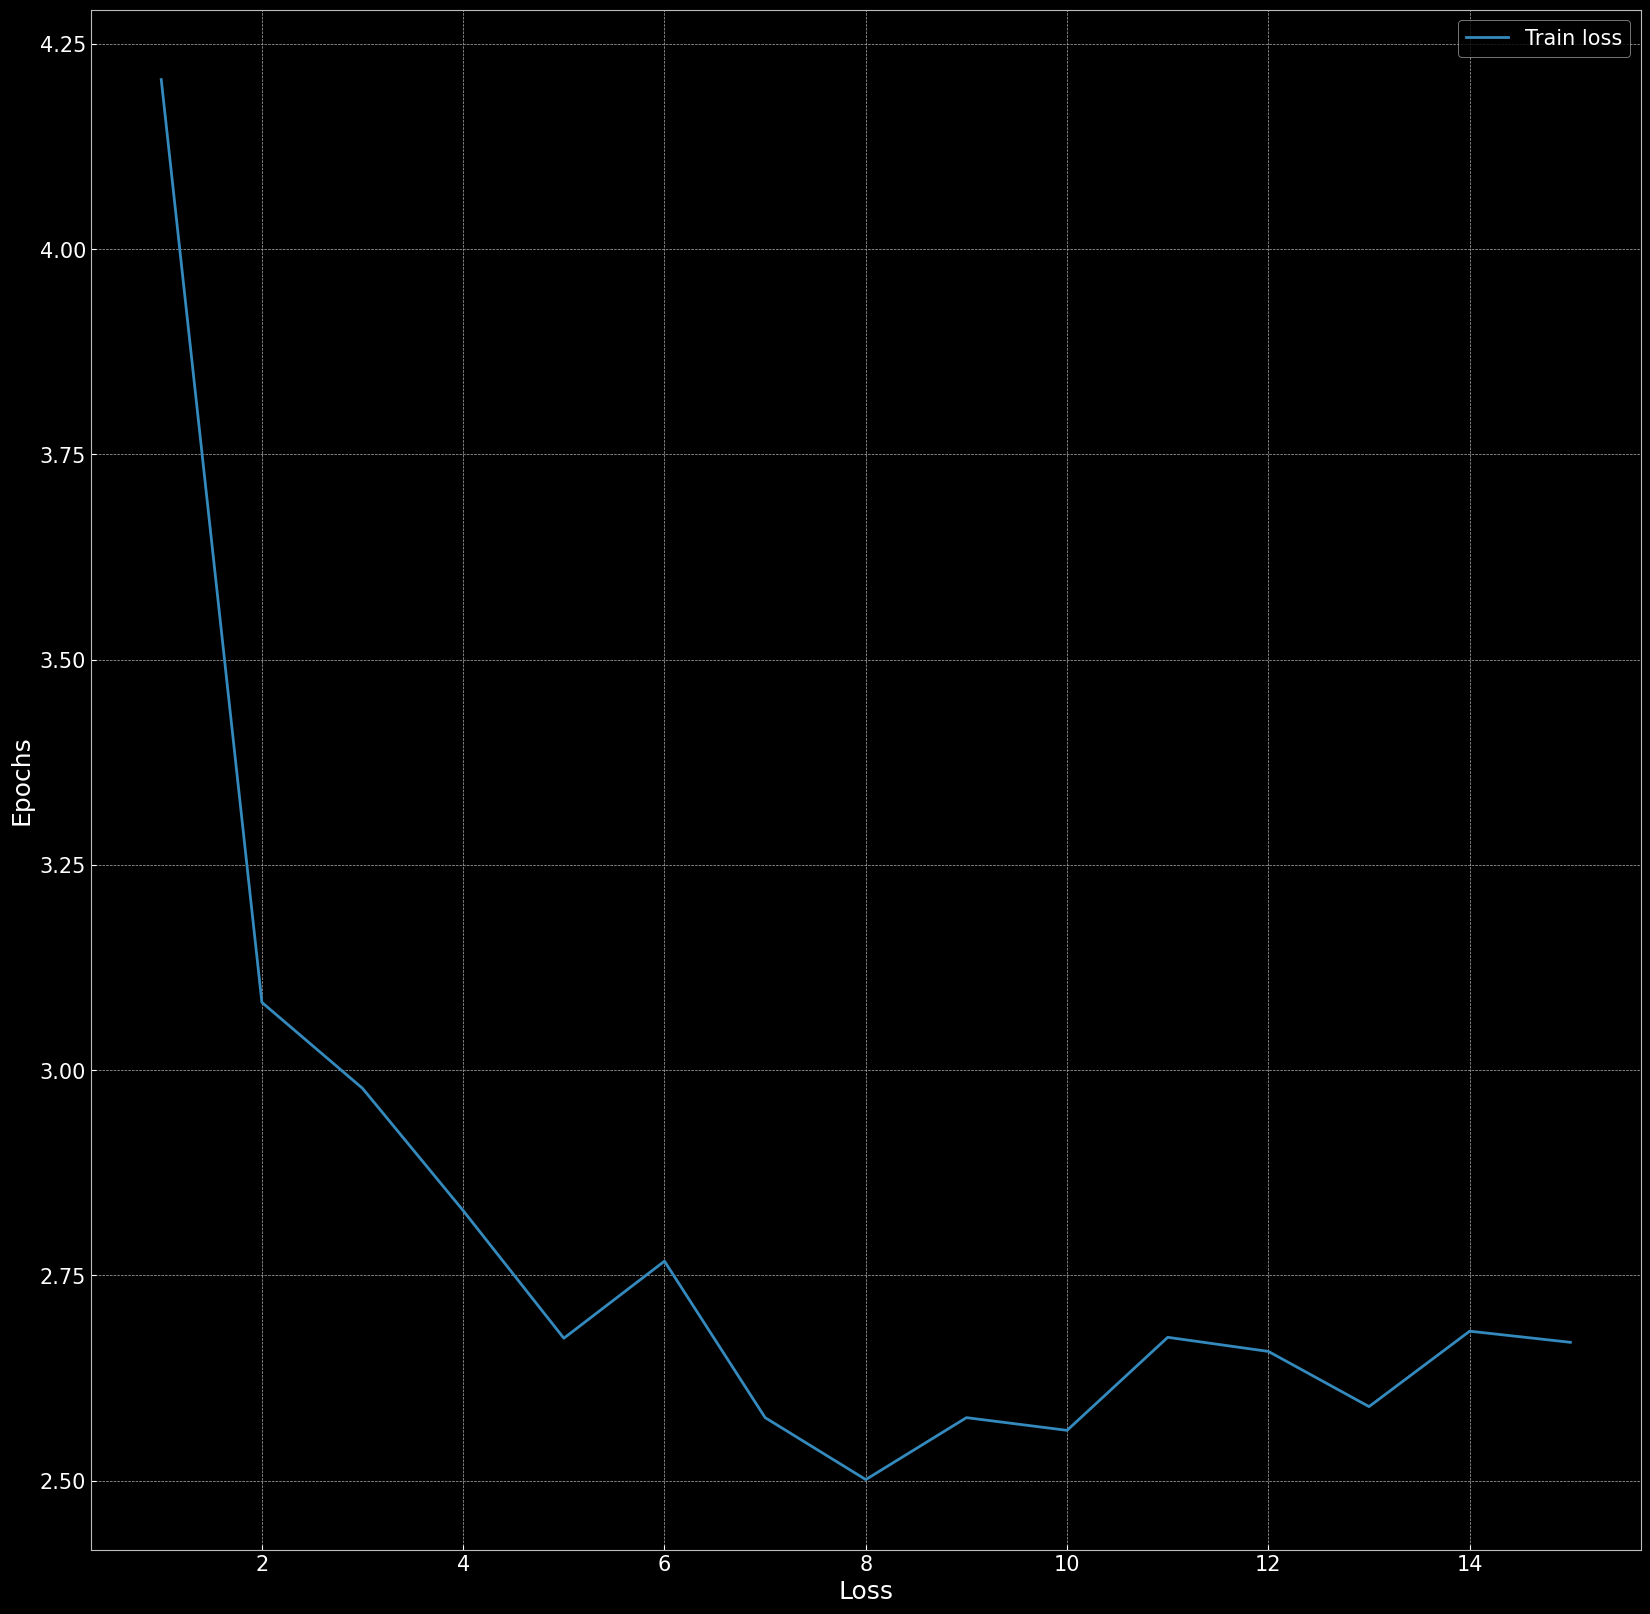

In [16]:
fig = plt.figure(figsize=(20, 20))
plt.plot(np.arange(1, len(loss_list) + 1), loss_list, label="Train loss")
plt.xlabel("Loss")
plt.ylabel("Epochs")
plt.legend(loc="upper right")

plt.show()

In [17]:
test_decode(m, 500)

tensor([[ 0, 25, 39, 15, 32, 39, 52,  8,  0, 20, 21, 51,  1, 15, 39, 32, 52,  0,
         53, 42,  6,  1, 45, 46, 46, 43, 56, 43, 12,  1, 39, 56, 53,  1, 41, 39,
         56, 52, 57,  6, 57,  1, 39, 56, 43, 43, 58,  1, 39, 57, 47, 52, 43, 58,
         46, 39, 50, 50,  1, 46, 63, 43, 60,  8,  0, 31,  0, 43,  8,  0, 15, 44,
         50, 39, 54, 43, 39, 58, 53,  5,  1, 58, 50, 56, 53, 51, 43,  1, 54, 53,
         59, 54, 39, 41, 56, 39, 41, 53, 41, 63, 53,  1, 61, 50, 43,  1, 42, 53,
         50, 42, 39, 43, 43,  1, 44,  8, 43,  0, 39, 54, 50, 39, 57,  1, 61, 47,
          1, 60, 53, 56,  1, 39, 52, 54,  1, 44, 47, 50, 50,  7, 50, 53, 56,  1,
         46, 47, 58, 39, 58, 47, 42,  1, 52, 54, 53, 52, 56, 39, 60,  1, 52, 43,
          1, 46, 43, 57, 47, 58, 46, 11,  1, 46, 39, 45, 42,  1, 42,  6,  1, 47,
         45, 52, 50, 45, 46,  1, 53, 46, 39,  2,  1, 43, 32,  1, 54, 39, 56, 43,
          1, 46, 58, 53, 39, 57, 43, 57, 60, 43,  1, 58, 43,  1, 61, 52,  1, 17,
         50,  1, 58, 46, 53,